# Load packages

In [3]:
import pandas as pd
import plotly.express as px
import numpy as np
import statsmodels.api as sm

# Load objects

In [4]:
df = pd.read_csv('../data/forecasting.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../data/forecasting.csv'

In [ ]:
s = df['CATEGORIES'].value_counts()[::-1]
fig = px.bar(s, height=800,width=800,orientation='h')
fig.update_layout(font=dict(size=5))



# Check number of categories per object

In [ ]:
# check how many elements
s = df['CATEGORIES'].str.split(',').apply(lambda x: len(x)).value_counts()

s / s.sum()

CATEGORIES
1    0.545356
2    0.451589
3    0.003054
Name: count, dtype: float64

# Cleanse categories based on category and subcategory combinations

In [ ]:
df['cat0'] = df['CATEGORIES'].str.split(',').apply(lambda x: x[0]).str.strip()
df['cat1'] = df['CATEGORIES'].str.split(',').apply(lambda x: x[1] if len(x)>1 else None).str.strip()
df['cat1'].value_counts().head(10)

cat1
FLAT              13935
FURNISHED_FLAT     1625
SINGLE_ROOM         928
ROOF_FLAT           591
DUPLEX              563
SHOP                424
COMMERCIAL          247
STUDIO              224
ATTIC_FLAT          215
STORAGE_ROOM        196
Name: count, dtype: int64

In [ ]:
cat2cat = df.groupby('cat1')['cat0'].apply(lambda x: x.value_counts().idxmax())
#cat2cat.value_counts()
cat2cat = cat2cat.replace('RETAIL_SPACE','RETAIL')
cat2cat.value_counts()

cat0
RETAIL                        12
APARTMENT                     11
HOUSE                          5
CAFE_BAR                       4
SHOP                           1
COVERED_PARKING_PLACE_BIKE     1
FLAT                           1
FACTORY                        1
OFFICE                         1
Name: count, dtype: int64

In [ ]:
df.loc[ df['cat0'].map(cat2cat).notnull(), 'cat1'] = df['cat0']
df['cat0'] = df['cat0'].map(cat2cat).fillna(df['cat0'])

In [ ]:
df['month'] = df['DATE'].str[:7]
df['quarter'] = pd.to_datetime(df['DATE']).dt.to_period('Q').astype(str)
df['year'] = df['DATE'].str[:4] #pd.to_datetime(df['DATE']).dt.to_period('Q').astype(str)


top_cats = df['cat0'].value_counts().index[:9].tolist()
df['cat0_'] = df['cat0'].apply(lambda x: x if x in top_cats else 'OTHER')
df_plot = df.groupby(['month','cat0_']).size().reset_index()
df_plot = df_plot.sort_values(by=0, ascending=False)
px.bar(df_plot,x='month',y=0,color='cat0_', width=1000,height=600)

# Check missing pricing info

In [ ]:
df_app = df[ df['cat0'] == 'APARTMENT' ].copy()
print( df_app['PRICE'].max() )
df_app['cat1'] = df_app['cat1'].str.replace('_FLAT','')
df_app['cat1'] = df_app['cat1'].fillna('N/A')
df_app['cat1_size'] = df_app['cat1'].map(df_app['cat1'].value_counts())
df_app = df_app.sort_values('cat1_size',ascending=False)

# remove extreme outliers
df_app = df_app[ ( df_app['PRICE'] <= 10_000 ) | df_app['PRICE'].isnull() ] #people mixed up rental and buy price
df_app = df_app[ ( df_app['PRICE'] >= 100 ) | df_app['PRICE'].isnull() ] #people mixed up rental and buy price

df_app['price_per_space'] = df_app['PRICE'] / df_app['SPACE']

top_cats = df_app['cat1'].value_counts().index.tolist()

def missing_info(row):
    if row['SPACE'] == '' and row['PRICE'] == '':
        return 'space and price'
    elif row['SPACE'] == '':
        return 'space'
    elif row['PRICE'] == '':
        return 'price'
    return 'none'

df_app['missing_info'] = df_app.fillna('').apply(missing_info,1)

fig = px.histogram(df_app,y='cat1',color='missing_info',width=1000,height=800) #,barnorm='percent')
fig = fig.update_layout(font_size=25).update_yaxes(categoryorder="total ascending")
fig.show()

870150.0


# Compre price vs sqm for apartment subcategories

In [ ]:
# only include appartments with sqm

df_app = df_app.sort_values('cat1_size',ascending=False)
fig = px.scatter( df_app, x='SPACE',y='PRICE',color='cat1',height=900,width=1000,opacity=0.5,marginal_x="histogram", marginal_y="histogram")#,trendline="ols")
fig = fig.update_layout(
    font_size=20,                    
    xaxis_title="sqm",
    yaxis_title="price"
)
fig.show()

In [ ]:
# Apartment subcategories over time

In [ ]:


df_app = df_app.sort_values('cat1_size',ascending=False)
fig = px.histogram(df_app,x='month',color='cat1',height=700,width=1000) #,barnorm='percent')
fig = fig.update_layout(bargap=0.1,bargroupgap=0.0,font_size=20,legend_title_text='')#.update_yaxes(categoryorder=top_cats)
fig.show()

# Distribution of apartment sizes over time

In [ ]:
def space_class(x):
    if x >= 90:
        return 'large'
    elif x >= 50:
        return 'medium'
    return 'small'

df_app['space_class'] = df_app['SPACE'].apply(space_class)
df_plot = df_app[ df_app['cat1'].isin(['FLAT','N/A','DUPLEX','ROOF']) ].copy()
df_plot = df_plot[ ( df_plot['price_per_space'] >= 10 ) & ( df_plot['price_per_space'] <= 40 ) ]
print(len(df_plot))

df_plot = df_plot.sort_values('quarter')
fig = px.histogram(df_plot, x='quarter', color='space_class', height=400, width=800, barnorm='percent')
fig.show()

25428


# Price/sqm distribution for different years

In [ ]:
# Assuming df_plot is already defined
fig = px.histogram(df_plot,x='price_per_space', color='year', width=1000, height=600,barmode='overlay')

# Change the bar color to red
# fig.update_traces(marker_color='darkred')

# Update layout to change the font size, remove the legend, and label the x-axis
fig.update_layout(
    font=dict(size=30),
    showlegend=True,
    xaxis_title="price/sqm",
    yaxis_title="#apartments"
)

# Show the plot
fig.show()

# Sample posterior of pricing trend parameter

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [price_per_space_sigma, Intercept, year_diff]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept              20.834  0.040  20.761   20.906      0.001    0.001   
year_diff               0.129  0.022   0.088    0.170      0.000    0.000   
price_per_space_sigma   4.016  0.018   3.982    4.050      0.000    0.000   

                       ess_bulk  ess_tail  r_hat  
Intercept                2652.0    1252.0    NaN  
year_diff                2782.0    1412.0    NaN  
price_per_space_sigma    2809.0    1478.0    NaN

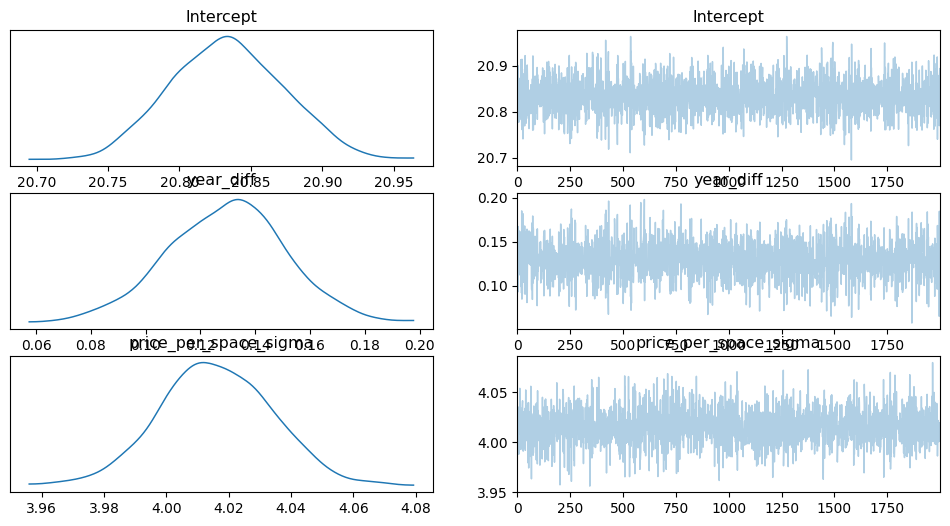

In [ ]:
import arviz as az
import bambi as bmb

df_plot['year_diff'] = df_plot['year'].astype(int)-2018

# Initialize the fixed effects only model
model = bmb.Model('price_per_space ~ year_diff', df_plot)

# Fit the model using 1000 on each of 4 chains
results = model.fit(draws=2000, chains=1)

# Use ArviZ to plot the results
az.plot_trace(results)

# Key summary and diagnostic info on the model parameters
az.summary(results)

In [ ]:
trend_low_quantile = np.quantile(results.posterior['year_diff'][0].values,0.05)
trend_high_quantile = np.quantile(results.posterior['year_diff'][0].values,0.95)
intercept = np.mean(results.posterior['Intercept'][0].values)

print(trend_low_quantile,trend_high_quantile,intercept)


0.09225875552810427 0.1649338415467438 20.833714218687863


# Plot pricing trend curve

In [ ]:
df_plot_year = df_plot.groupby(['year'])['price_per_space'].mean().round(1).reset_index()
df_plot_year = pd.concat([df_plot_year,pd.DataFrame([{'year':'2022'}])],ignore_index=True)
df_plot_year['year_diff'] = df_plot_year['year'].astype(int)-2018


df_plot_year['price_per_space_high'] = (intercept + df_plot_year['year_diff']*trend_high_quantile).round(1)
df_plot_year['price_per_space_low'] = (intercept + df_plot_year['year_diff']*trend_low_quantile).round(1)

#df_plot_year = df_plot_year.fillna(0)


# hacky
df_plot_year.loc[df_plot_year['year']<'2022','price_per_space_high'] = df_plot_year['price_per_space']
df_plot_year.loc[df_plot_year['year']<'2022','price_per_space_low'] = df_plot_year['price_per_space']

OverflowError: Python int too large to convert to C long

In [ ]:
import plotly.graph_objects as go

# Assuming df_plot_year is your DataFrame and it has a 'year' column

# Create a list with all values being None except the last one for price_per_space_high
high_labels = [None] * len(df_plot_year['price_per_space_high'])
high_labels[-1] = df_plot_year['price_per_space_high'].iloc[-1]  # Set the last label

trace_high = go.Scatter(
    x=df_plot_year['year'],  # Use 'year' column for x-axis
    y=df_plot_year['price_per_space_high'],
    line=dict(color='red',width=3),
    name='High',
    fill=None,
    showlegend=False,  # This will remove the legend entry for this trace
    text=high_labels,  # Only label the last dot
    mode='lines+markers+text',  # Add both lines, markers, and text
    textposition='top center'  # Position the text above the dot
)

trace_low = go.Scatter(
    x=df_plot_year['year'],  # Use 'year' column for x-axis
    y=df_plot_year['price_per_space_low'],
    line=dict(color='red',width=3),
    name='Low',
    fill='tonexty',
    showlegend=False,  # This will remove the legend entry for this trace
    text=df_plot_year['price_per_space_low'],  # Label all the dots
    mode='lines+markers+text',  # Add both lines, markers, and text
    textposition='bottom center'  # Position the text below the dots
)

layout = go.Layout(
    #title='Area Chart between price_per_space_low and price_per_space_high',
    xaxis=dict(
        title='year',  # Changed x-axis label to 'Year'
        titlefont=dict(size=30)  # Set font size to 20
    ),
    yaxis=dict(
        title='price/sqm',  # Changed y-axis label to 'Price/sqm'
        titlefont=dict(size=30),  # Set font size to 20
        showticklabels=False  # Remove the ticks on the y-axis
    ),
    font=dict(size=20),  # Set global font size to 20
    showlegend=False,  # This will remove the legend
    height=800,  # Set height to 800
    width=800  # Set width to 800
)

fig = go.Figure(data=[trace_high, trace_low], layout=layout)
fig.update_layout(font_size=25)
fig.show()
